<h1 align = "center"> Отток клиентов <h1>

---

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

- `RowNumber` — индекс строки в данных


- `CustomerId` — уникальный идентификатор клиента


- `Surname` — фамилия


- `CreditScore` — кредитный рейтинг


- `Geography` — страна проживания


- `Gender` — пол


- `Age` — возраст


- `Tenure` — количество недвижимости у клиента


- `Balance` — баланс на счёте


- `NumOfProducts` — количество продуктов банка, используемых клиентом


- `HasCrCard` — наличие кредитной карты


- `IsActiveMember` — активность клиента


- `EstimatedSalary` — предполагаемая зарплата



- **`Exited` — факт ухода клиента** - целевой признак

# План проекта

1. [Подготовка данных](#1)

    - [Предобработка данных](#1.1)
    
    - [Обучающая и тестовая выборки](#1.2)
    
    - [Стандартизация данных](#1.3)


2. [Исследование задачи](#2)

    - [Дисбаланс классов](#2.1)
    
    - [Модель случайного леса](#2.2)
    
    - [Модель логистической регрессии](#2.3)


3. [Борьба с дисбалансом](#3)

    - [Модель случайного леса](#3.1)
    
    - [Модель логистической регрессии](#3.2)


4. [Тестирование моделей](#4)


5. [Вывод](#5)

In [1]:
# импорт данных

import pandas as pd
import numpy as np
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

<a id="1"></a>

# 1. Подготовка данных

<a id="1.1"></a>

## Предобработка данных

In [2]:
# читаем данные

try:
    data = pd.read_csv('Churn.csv', index_col='RowNumber')
    
except:
    data = pd.read_csv('/datasets/Churn.csv', index_col='RowNumber')

Судя по описанию данных, колонка `RowNumber` содержит не полезную информацию о конкретном клиенте, а просто указывает, на какой позиции находилась данная строчка в исходной БД. Поэтому мы явно указали выбрать эту колонку в качестве индекса для нашего датафрейма, т.к. этот параметр не влияет на факт ухода клиента, и таким образом мы исключим его из признаков, на которых будут обучатся наши модели

In [3]:
# вызываем первые 5 строк данных, их типы и метод info()

display(data.head())

data_types = pd.DataFrame(data = data.dtypes, columns=['dtype'])
display(data_types)

data.info()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,dtype
CustomerId,int64
Surname,object
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,float64
Balance,float64
NumOfProducts,int64
HasCrCard,int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


С типами данных все впорядке, за исключением колонки `Tenure`

Видно, что в колонке `Tenure` есть около 10% пропусков (это и объясняет нецелый тип данных). А сама колонка содержит информацию о количестве недвижимости у клиента. Так как мы не имеем возможно корректно заполнить пропуски в этом признаке, а некоторые модели машинного обучение чувствительны к наличию пропусков - удалим строчки, в которых есть пропуски

In [4]:
# удаляем пропуски в данных

data.dropna(axis=0, subset=['Tenure'], inplace=True)

# поменяем тип данных в колонке, чтобы он соответствовал логике величины

data['Tenure'] = data['Tenure'].astype('int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 1 to 9999
Data columns (total 13 columns):
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null int64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(2), int64(8), object(3)
memory usage: 994.3+ KB


У нас есть такие признаки как `Surname`, `Geography` и `Gender` - они имеют тип данных *object*, который скорее всего не сможет быть корректно обработан библиотекой sklearn

Первый можем просто удалить так как мы будем исходить из предположения, что фамилия никак не влияет на факт ухода клиента из банка. Также вместе с этим столбцом можно удалить и столбец `CustomerID` так как он несет практически такую же смысловую нагрузку, за исключением того, что уникален для каждого клиента

Второй и третий признаки преобразуем с помощью техники **OHE**

In [5]:
# удаляем столбцы 'Surname' и 'CustomerId'

data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [6]:
# кодируем признак 'Gender' с помощью OHE
# признак может принимает всего 2 значения, поэтому уберем один из столбцов, чтобы не попасть в дамми-ловушку

data_ohe = pd.get_dummies(data, columns=['Gender'], drop_first=True)

# кодируем признак 'Geography' с помощью OHE
# признак вообще говоря может принимать любые значения, поэтому сохраним все получаемые столбцы

data_ohe = pd.get_dummies(data_ohe, columns=['Geography'], drop_first=False)

In [7]:
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 1 to 9999
Data columns (total 13 columns):
CreditScore          9091 non-null int64
Age                  9091 non-null int64
Tenure               9091 non-null int64
Balance              9091 non-null float64
NumOfProducts        9091 non-null int64
HasCrCard            9091 non-null int64
IsActiveMember       9091 non-null int64
EstimatedSalary      9091 non-null float64
Exited               9091 non-null int64
Gender_Male          9091 non-null uint8
Geography_France     9091 non-null uint8
Geography_Germany    9091 non-null uint8
Geography_Spain      9091 non-null uint8
dtypes: float64(2), int64(7), uint8(4)
memory usage: 745.7 KB


Хочется переименовать колонки, чтобы все имели единообразные имена

In [8]:
# переименовываем колонки в соответствии с внутренним чувством стиля

new_columns_names = ['credit_score', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary',
       'exited', 'gender_male', 'geography_france', 'geography_germany',
       'geography_spain']

data_ohe.set_axis(new_columns_names, axis=1, inplace=True)

Выделим в отдельные датафреймы фичи и целевой признак

In [9]:
# выделяем целевой признак

target = data_ohe['exited']
features = data_ohe.drop(['exited'], axis=1)

<a id="1.2"></a>

## Обучающая и тестовая выборки

Разделим данные на две выборки - обучающую и тестовую в соотношении: **3:1**

Для этого воспользуемся функцией **tarin_test_split** из библиотеки sklearn

In [10]:
# разбиваем данные на обучающую  тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)


print('Размер обучающей выборки', features_train.shape[0], 'объектов')
print()
print('Размер тестовой выборки', features_test.shape[0], 'объектов')

Размер обучающей выборки 6818 объектов

Размер тестовой выборки 2273 объектов


<a id="1.3"></a>

## Стандартизация выборок

Перед тем как приступать к обучению моделей, обратим внимание что в предоставленных данных все признаки имеют разные масштабы, например, `age` и `estimated_salary`. Для того чтобы избежать ошибок при обучении моделей, стандартизируем все количественные признаки

In [11]:
# список количественных признаков

numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products','estimated_salary']

# создаем копии датафреймов с признаками, чтобы при стандартизации не любоваться на предупреждение от pandas

features_train_norm = features_train.copy()
features_test_norm = features_test.copy()

In [12]:
# стандартизируем данные

scaler = StandardScaler()

scaler.fit(features_train[numeric]) 

features_train_norm[numeric] = scaler.transform(features_train[numeric])

Нужно стандартизировать и тестовую выборку

In [13]:
# создаем копию тестовых данных

features_test_norm = features_test.copy()

# стандартизируем созданную копию

features_test_norm[numeric] = scaler.transform(features_test[numeric])

### Промежуточный вывод

В результате предобработки данных проведено:

1. Удалены строки с пропусками


2. Удалены столбцы `Surname` и `CustomerId` так как они не влияют на уход клиента из банка


3. Признаки `Gender` и `Geography` закодированы с помощью OHE


4. Переименованы колонки для единообразия всех названий


5. Данные разделены на обучающую и тестовую выборки в соотношении - 3:1


6. Стандартизированы обучающая и тестовая выборки

<a id="2"></a>

# 2. Исследование задачи

<a id="2.1"></a>

## Оценим дисбаланс классов в обучающей выборке

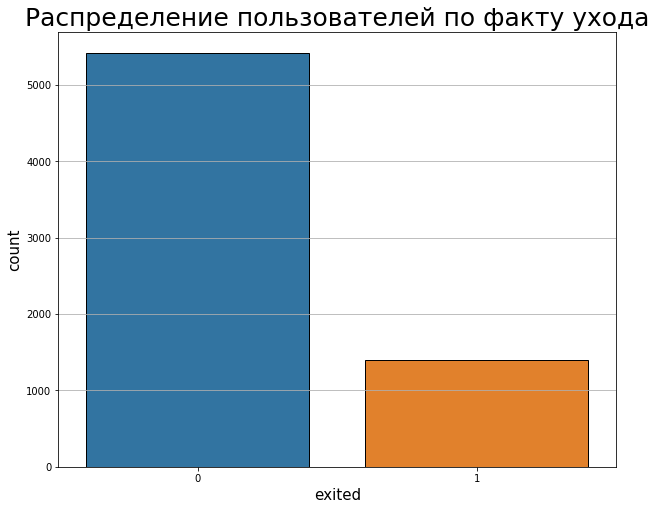

In [14]:
# считаем количество объектов каждого класса

classes_count = pd.DataFrame(target_train.value_counts())

# добавим график

ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=classes_count.index, y=classes_count['exited'], data=classes_count, edgecolor='black')
ax.grid(axis='y')
ax.set_xlabel('exited', fontsize=15)
ax.set_ylabel('count', fontsize=15)
ax.set_title('Распределение пользователей по факту ухода', fontsize=25)

plt.show()

Пользователей, которые остались клиентами банка значительно больше, чем ушедших. Это может повлиять на качество обучаемых моделей. Проверим это предположение и обучим модель без учета этого факта.

Фактически мы решаем задачу классификации - распределяем клиентов по 2 группам. Поэтому для обучения выберем две модели - **случайный лес** и **логистическую регрессию**.

<a id="2.2"></a>

## Случайный лес

Для поиска наилучшей модели воспользуемся **GridSearchCV**.

Будем варьировать два гиперпараметра:

- `n_estimators` - от 1 до 251 с шагом в 10

- `max_depth` - от 1 до 50 с шагом в 1

Так же воспользуемся кросс валидацией

In [15]:
%%time

# подбираем лучшие параметры для модели случайного леса - количество дреевьев от 1 до 251, глубина от 1 до 50
# обучение проводим сразу на всех ядрах процессора - параметр n_jobs=-1
# делим обучающую выборку на 3 и используем кросс валидацию

gs = GridSearchCV(RandomForestClassifier(random_state=42),
                        param_grid={'n_estimators': range(1,252,10), 'max_depth': range(1,51)},
                        scoring='f1',
                        n_jobs=-1,
                        cv=3,
                        return_train_score=True)

gs.fit(features_train_norm, target_train)

# выводим лучшие параметры на экран

gs.best_params_

Wall time: 5min 31s


{'max_depth': 26, 'n_estimators': 141}

В результате вариации параметров, лучший результат по метрике **F1** получили при 141 деревьях глубиной 26

In [16]:
%%time

#  обучаем модель с наибольшим значением F1

best_forest_model = RandomForestClassifier(max_depth= 26, n_estimators= 141, random_state=42)

best_forest_model.fit(features_train_norm, target_train)

# предсказываем значение целевого признака по обучающей и тестовой выборке

predicted_train = best_forest_model.predict(features_train_norm)
predicted_test = best_forest_model.predict(features_test_norm)

# считаем метрику F1 

print('F1 на обучающей', f1_score(target_train, predicted_train))
print('F1 на тестовой', f1_score(target_test, predicted_test))

F1 на обучающей 1.0
F1 на тестовой 0.5606694560669456
Wall time: 830 ms


<a id="2.3"></a>

## Логистическая регрессия

Для поиска наилучшей модели снова воспользуемся **GridSearchCV**.

Варьировать будем только один параметр - `max_iter` от 10 до 10000 с шагом 10

In [17]:
%%time

# подбираем наилучшие параметры для модели логистической регрессии

gs = GridSearchCV(LogisticRegression(random_state=12345, solver='liblinear'),
                                    param_grid={'max_iter': range(10, 10000, 10)},
                                    scoring='f1',
                                     n_jobs=-1,
                                    cv=3,
                                    return_train_score=True)
                  
gs.fit(features_train_norm, target_train)
                  
# выводим лучшие параметры на экран

gs.best_params_

Wall time: 6.68 s


{'max_iter': 10}

In [18]:
%%time

#  обучаем модель с наибольшим значением F1

best_regression_model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=10)

best_regression_model.fit(features_train_norm, target_train)

# предсказываем значение целевого признака по обучающей и тестовой выборке

predicted_train = best_regression_model.predict(features_train_norm)
predicted_test = best_regression_model.predict(features_test_norm)

# считаем метрику F1 

print('F1 на обучающей', f1_score(target_train, predicted_train))
print('F1 на тестовой', f1_score(target_test, predicted_test))

F1 на обучающей 0.32224532224532226
F1 на тестовой 0.3144246353322528
Wall time: 16 ms


### Промежуточный вывод

1. Для обучения было выбрано две модели - случайный лес и логистическая регрессия


2. С помощью GridSearchCV для выбранных моделей были выбраны параметры, максимизирующие метрику **F1**

    - лес
        - max_depth= 26
        - n_estimators= 141
        
    - регрессия
        - solver='liblinear'
        - max_iter=10
        
3. Модель рандомного леса показывает более высокое значение F1 на тестовой выборке:

    - лес = 0.5606694560669456
    
    - регрессия = 0.3144246353322528
    

4. Время, которое обучается модель рандомного леса значительно превышает время обучения модели регрессии

    - лес ~ 830 ms
    
    - регрессия ~ 15 ms
    
    
5. Без учета дисбаланса классов метрика F1 так и не достигла необходимого порогового значения 0.59

<a id="3"></a>

# 3. Борьба с дисбалансом

<a id="3.1"></a>

## Рандомный лес

Поскольку данных достаточно мало, то воспользуемся техникой **upsampling**

In [19]:
# функция для upsampling

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Определим во сколько раз нужно увеличить число объектов положительного класса

In [20]:
repeat = int(round(target_train.value_counts()[0] / target_train.value_counts()[1]))

print('Нужно увеличить число объектов положительного класса в {} раз(а)'.format(repeat))

Нужно увеличить число объектов положительного класса в 4 раз(а)


In [21]:
# апсемплим обучающую выборку

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

Теперь нужно снова стандартизировать наши данные

In [22]:
# создаем копию дополненных данных

features_upsampled_norm = features_upsampled.copy()

# стандартизируем созданную копию

features_upsampled_norm[numeric] = scaler.transform(features_upsampled[numeric])

In [23]:
%%time

# подбираем лучшие параметры для модели случайного леса - количество дреевьев от 1 до 350, глубина от 1 до 50
# обучение проводим сразу на всех ядрах процессора - параметр n_jobs=-1
# делим обучающую выборку на 3 и используем кросс валидацию

gs = GridSearchCV(RandomForestClassifier(random_state=42),
                        param_grid={'n_estimators': range(1,350,10), 'max_depth': range(1,51)},
                        scoring='f1',
                        n_jobs=-1,
                        cv=3,
                        return_train_score=True)

gs.fit(features_upsampled_norm, target_upsampled)

# выводим лучшие параметры на экран

gs.best_params_

Wall time: 15min 24s


{'max_depth': 22, 'n_estimators': 211}

В результате вариации параметров, лучший результат по метрике **F1** получили при 211 деревьях глубиной 22

In [24]:
%%time

#  обучаем модель с наибольшим значением F1

best_upsampled_forest_model = RandomForestClassifier(max_depth= 11, n_estimators= 341, random_state=42)

best_upsampled_forest_model.fit(features_upsampled_norm, target_upsampled)

# предсказываем значение целевого признака по обучающей и тестовой выборке

predicted_train = best_upsampled_forest_model.predict(features_upsampled_norm)
predicted_test = best_upsampled_forest_model.predict(features_test_norm)

# считаем метрику F1 


print('F1 на обучающей', f1_score(target_upsampled, predicted_train))
print('F1 на тестовой', f1_score(target_test, predicted_test))

F1 на обучающей 0.9431039088237912
F1 на тестовой 0.6120331950207468
Wall time: 2.52 s


<a id="3.2"></a>

## Логистическая регрессия

В случае модели логистической регрессии попробуем применить другой способ учета дисбаланса класа - при обучении модели сбалансируем веса положительного и отрицательного класса

In [25]:
%%time

#  обучаем модель с наибольшим значением F1 на взвешенных данных

best_balanced_regression_model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

best_balanced_regression_model.fit(features_train_norm, target_train)

# предсказываем значение целевого признака по обучающей и тестовой выборке

predicted_train = best_balanced_regression_model.predict(features_train_norm)
predicted_test = best_balanced_regression_model.predict(features_test_norm)

# считаем метрику F1 

print('F1 на обучающей', f1_score(target_train, predicted_train))
print('F1 на тестовой', f1_score(target_test, predicted_test))

F1 на обучающей 0.504919730709477
F1 на тестовой 0.4772036474164133
Wall time: 14 ms


Проверим как изменится метрика F1 если обучать модель логистической регрессии на семплированной обучающей выборке. При этом не будем менять дефолтное значения `class_weight`

In [26]:
%%time

#  обучаем модель с наибольшим значением F1 на семплированных данных

best_upsampled_regression_model = LogisticRegression(random_state=12345, solver='liblinear')

best_upsampled_regression_model.fit(features_upsampled_norm, target_upsampled)

# предсказываем значение целевого признака по обучающей и тестовой выборке

predicted_train = best_upsampled_regression_model.predict(features_upsampled_norm)
predicted_test = best_upsampled_regression_model.predict(features_test_norm)

# считаем метрику F1 

print('F1 на обучающей', f1_score(target_upsampled, predicted_train))
print('F1 на тестовой', f1_score(target_test, predicted_test))

F1 на обучающей 0.7171917191719173
F1 на тестовой 0.47442550037064485
Wall time: 18.9 ms


### Промежуточный вывод

1. С помощью GridSearchCV для выбранных моделей были выбраны параметры, максимизирующие метрику **F1**

    - лес
        - max_depth= 11
        - n_estimators= 341
        
    - регрессия
        - solver='liblinear'
        - max_iter= default
        - class_weight = 'balanced'
        
3. Модель рандомного леса показывает более высокое значение F1 на тестовой выборке:

    - лес = 0.6120331950207468
    
    - регрессия = 0.4772036474164133
    

4. Время, которое обучается модель рандомного леса значительно превышает время обучения модели регрессии

    - лес ~ 2.5 s
    
    - регрессия ~ 15 ms
    
    
5. Дисбаланс классов был учтен двумя способами:

    - методом upsampling для модели рандомного леса и логистической регрессии
    - балансированием классов для модели логистической регрессии

<a id="4"></a>

# 4. Тестирование модели

Несмотря на то, чтол ранее все модели были уже протестированы на тестовой выборке - приведем результаты теста еще раз и построим график метрики F1 в зависимости от модели. При этом для проверки адекватности модели - приведем результаты для модели, которая проводит классификацию клиентов случайным образом.

In [27]:
# список с названиями моделей и список для хранения F1 для всех моделей 

model_names = ['RandomForest upsampled', 'LogisticRegression balanced',
              'LogisticRegression upsampled', 'Dummy']
model_numbers = [1,2,3,4]

model_scores = []

In [28]:
# лучшая модель рандомного леса upsampling

predicted_test = best_upsampled_forest_model.predict(features_test_norm)
print('RandomForest upsampled F1 на тестовой', f1_score(target_test, predicted_test))
print()
model_scores.append(f1_score(target_test, predicted_test))



# лучшая модель рандомной регрессии с балансом классов

predicted_test = best_balanced_regression_model.predict(features_test_norm)
print('LogisticRegression balanced F1 на тестовой', f1_score(target_test, predicted_test))
print()
model_scores.append(f1_score(target_test, predicted_test))



# лучшая модель рандомной регрессии upsampling

predicted_test = best_upsampled_regression_model.predict(features_test_norm)
print('LogisticRegression upsampled F1 на тестовой', f1_score(target_test, predicted_test))
print()
model_scores.append(f1_score(target_test, predicted_test))



# для проверки адекватности модели посчитаем f1 для Dummy модели

dummy = DummyClassifier(random_state = 3, strategy = 'uniform')
dummy.fit(features_train, target_train)
predicted_test = dummy.predict(features_test)
print('Dummy F1 на тестовой', f1_score(target_test, predicted_test))
print()
model_scores.append(f1_score(target_test, predicted_test))

RandomForest upsampled F1 на тестовой 0.6120331950207468

LogisticRegression balanced F1 на тестовой 0.4772036474164133

LogisticRegression upsampled F1 на тестовой 0.47442550037064485

Dummy F1 на тестовой 0.28645495787427094



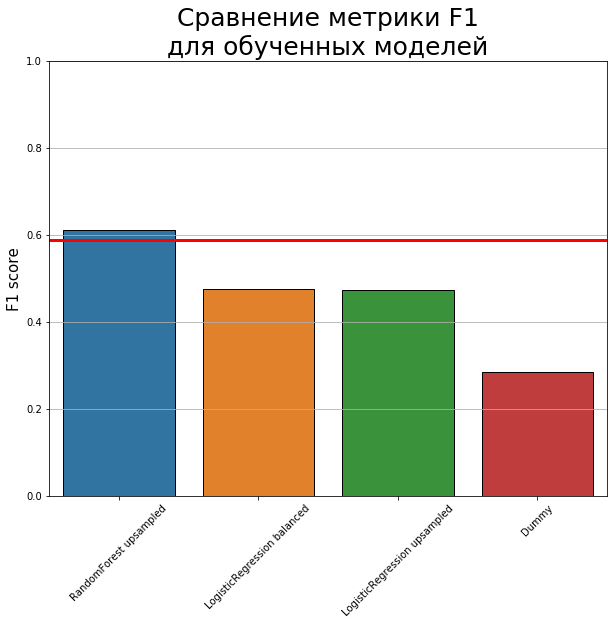

In [29]:
# добавим график

ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=model_numbers , y=model_scores, edgecolor='black')
ax.grid(axis='y')
ax.set_ylabel('F1 score', fontsize=15)
ax.set_title('Сравнение метрики F1\nдля обученных моделей', fontsize=25)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0,1)

plt.axhline(y=0.59, linewidth=3, color='red') # обозначим красной горизонтальной линией порог по F1
plt.show()

Теперь для обученных моделей посчитаем AUC ROC и снова построим график

In [30]:
# список для сохранения AUC ROC для моделей

model_auc = []

In [31]:
# лучшая модель рандомного леса upsampling

probabilities_test =  best_upsampled_forest_model.predict_proba(features_test_norm)
probabilities_one_test = probabilities_test[:, 1]

print('RandomForest upsampled AUC ROC на тестовой', roc_auc_score (target_test, probabilities_one_test))
print()
model_auc.append(roc_auc_score (target_test, probabilities_one_test))


# лучшая модель рандомной регрессии с балансом классов

probabilities_test =  best_balanced_regression_model.predict_proba(features_test_norm)
probabilities_one_test = probabilities_test[:, 1]

print('LogisticRegression balanced AUC ROC на тестовой', roc_auc_score (target_test, probabilities_one_test))
print()
model_auc.append(roc_auc_score (target_test, probabilities_one_test))


# лучшая модель рандомной регрессии upsampling

probabilities_test =  best_upsampled_regression_model.predict_proba(features_test_norm)
probabilities_one_test = probabilities_test[:, 1]

print('LogisticRegression upsampled AUC ROS на тестовой', roc_auc_score (target_test, probabilities_one_test))
print()
model_auc.append(roc_auc_score (target_test, probabilities_one_test))


# для проверки адекватности модели посчитаем f1 для Dummy модели

dummy = DummyClassifier(random_state = 3, strategy = 'uniform')
dummy.fit(features_train, target_train)
probabilities_test = dummy.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]


print('Dummy AUC ROC на тестовой', roc_auc_score (target_test, probabilities_one_test))
print()
model_auc.append(roc_auc_score (target_test, probabilities_one_test))

RandomForest upsampled AUC ROC на тестовой 0.8520288233666559

LogisticRegression balanced AUC ROC на тестовой 0.7548895064178907

LogisticRegression upsampled AUC ROS на тестовой 0.7549207838608395

Dummy AUC ROC на тестовой 0.5



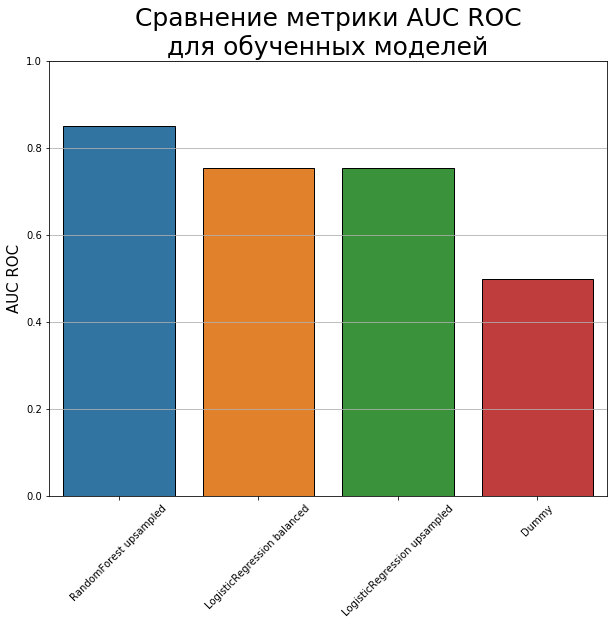

In [32]:
# добавим график

ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=model_numbers , y=model_auc, edgecolor='black')
ax.grid(axis='y')
ax.set_ylabel('AUC ROC', fontsize=15)
ax.set_title('Сравнение метрики AUC ROC\nдля обученных моделей', fontsize=25)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0,1)

plt.show()

<a id="5"></a>

## Вывод

В результате проекта были обучены два типа моделей - рандомный лес и логистическая регресиия:

1. были обучены модели без учета дисбаланса классов, метрика F1 равна:

    - лес = 0.5606694560669456
    - регрессия = 0.3144246353322528
    
    
2. был проведен учет дисбаланска классов:

    - upsampling - для леса и регрессии
    - баланс веса - для регрессии
    
   
3. были обучены модели с учетом дисбаланса классов, метрика F1 равна:

    - лес = 0.6120331950207468
    - регрессия = 0.4772036474164133
    
    Несмотря на явное преимущество модели рандомного леса по метрике F1 необходимо также учитывать, что обучение моделей леса занимает на несколько порядков больше времени, по сравнению с обучением модели логистической регрессии